In [1]:
import pandas as pd
import numpy as np

# === Parametri ===
csv_path = "csv/Jobstats12345678rep0.csv"   # <-- metti qui il path del tuo file

# === Lettura robusta del CSV ===
df = pd.read_csv(
    csv_path,
    sep=",",
    decimal=",",
    engine="python",
    on_bad_lines="skip"
)

# Normalizza nomi colonne
df.columns = [c.strip() for c in df.columns]

required_cols = ["JobID","Arrival","Departure","ResponseTime","OriginalSize"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Mancano colonne richieste: {missing}")

# Converto a numerico
for c in ["Arrival","Departure","ResponseTime","OriginalSize"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Elimino righe senza JobID
df = df.dropna(subset=["JobID"]).copy()

# === Check 1: Timing ===
lhs = df["Arrival"].to_numpy() + df["OriginalSize"].to_numpy()
rhs = df["Departure"].to_numpy() + eps
df["TimingOK"] = lhs <= rhs

# === Check 2: slowdown ===
size_zero_mask = (df["OriginalSize"] <= 0) | df["OriginalSize"].isna()
df["Slowdown"] = np.where(size_zero_mask, np.nan, df["ResponseTime"] / df["OriginalSize"])

# === Check 3: completati ===
df["Completed"] = ~df["ResponseTime"].isna()

# === Statistiche ===
total = len(df)
timing_fail = (~df["TimingOK"]).sum()
completed_cnt = df["Completed"].sum()

# Tempo medio di risposta (solo completati)
mean_response_time = df.loc[df["Completed"], "ResponseTime"].mean()

print("=== VERIFICA CSV JOBS ===")
print(f"Job totali       : {total}")
print(f"Timing OK        : {df['TimingOK'].sum()} / {total} (KO={timing_fail})")
print(f"Job completati   : {completed_cnt} / {total}")
print(f"Tempo medio risposta (solo completati): {mean_response_time:.6f} s")

# === Salvataggio CSV arricchito ===
out_path = "jobs_with_checks.csv"
df.to_csv(out_path, index=False)

# Aggiungo riga summary
with open(out_path, "a") as f:
    f.write(f"\nSUMMARY,,,,,MeanResponseTime={mean_response_time:.6f}\n")

valid_slowdown = df["Slowdown"].dropna()
if not valid_slowdown.empty:
    print("\n=== Slowdown (ResponseTime / OriginalSize) ===")
    print(f"count={valid_slowdown.count()}, mean={valid_slowdown.mean():.6f}, "
          f"p50={valid_slowdown.quantile(0.5):.6f}, p95={valid_slowdown.quantile(0.95):.6f}, "
          f"max={valid_slowdown.max():.6f}")
else:
    print("\nNessuno slowdown calcolabile (OriginalSize==0 o mancante).")

print(f"\nSalvato: {out_path}")


FileNotFoundError: [Errno 2] No such file or directory: 'csv/Jobstats12345678rep0.csv'

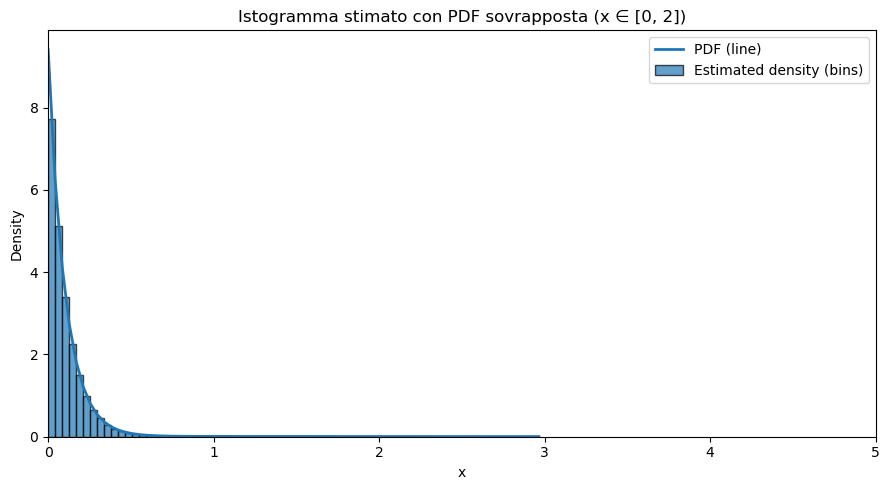

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# === Percorsi dei file ===
bars_csv = "csv/hyperexponential_histogram.csv"      # <-- CSV con colonne: x, estimated_density
line_csv = "csv/hyperexponential_theoretical.csv"          # <-- CSV con colonne: x, pdf

# === Carica dati ===
bars = pd.read_csv(bars_csv)
line = pd.read_csv(line_csv)

# === Taglia a [0, 2] ===
bars = bars[(bars["x"] >= 0) & (bars["x"] <= 3)].copy()
line = line[(line["x"] >= 0) & (line["x"] <= 3)].copy()

# Assicurati che ci siano almeno due punti per creare intervalli
if len(bars) < 2:
    raise ValueError("Servono almeno due punti in 'density.csv' nel range [0, 2] per costruire le barre.")

# === Prepara intervalli [x_i, x_{i+1}) per le barre ===
x_start = bars["x"].values[:-1]
x_end   = bars["x"].values[1:]
heights = bars["estimated_density"].values[:-1]
widths  = x_end - x_start

# === Plot ===
fig, ax = plt.subplots(figsize=(9,5))

# Barre (istogramma stimato)
ax.bar(x_start, heights, width=widths, align="edge", edgecolor="black", alpha=0.7, label="Estimated density (bins)")

# Linea (pdf teorica)
ax.plot(line["x"].values, line["pdf"].values, linewidth=2, label="PDF (line)")

ax.set_xlim(0, 5)
#ax.set_ylim(0, 5)
ax.set_xlabel("x")
ax.set_ylabel("Density")
ax.set_title("Istogramma stimato con PDF sovrapposta (x ∈ [0, 2])")
ax.legend()
plt.tight_layout()
plt.show()



In [1]:
import pandas as pd

df = pd.read_csv("csv/Servers.csv")
df.head()


,timestamp,active_jobs_per_webserver,active_web_servers,active_jobs_spikeserver
0,0.044401,"[null, 1]",1.0,0.0
1,0.044401,it.pmcsn.lbsim.models.domain.LoadBalancer@1f3f...,NaN,NaN
2,0.050885,"[null, 2]",1.0,0.0
3,0.050885,it.pmcsn.lbsim.models.domain.LoadBalancer@1f3f...,NaN,NaN
4,0.070792,"[null, 1]",1.0,0.0


In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
# Convertiamo i secondi in minuti
minutes = df["timestamp"] / 60.0

plt.step(minutes, df["active_web_servers"], where="post")
plt.xlabel("Tempo (minuti)")
plt.ylabel("Numero di server attivi")
plt.title("Server attivi nel tempo")
plt.grid(True)

# Assicura che le ordinate abbiano solo numeri interi
plt.yticks(range(int(df["active_web_servers"].min()), int(df["active_web_servers"].max()) + 1))

plt.show()


NameError: name 'df' is not defined

<Figure size 1000x400 with 0 Axes>

In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt

def parse_jobs_json(val):
    if pd.isna(val):
        return []
    s = str(val).strip()
    if s == "" or s.lower() == "nan":
        return []
    # parse JSON come ["null", 1] -> [None, 1]
    try:
        return json.loads(s)
    except json.JSONDecodeError:
        # fallback: prova a ripulire e riparsare
        return json.loads(s.replace("'", '"'))

# Assumo che df esista e abbia le colonne:
# - "timestamp"
# - "active_jobs_per_webserver" come stringhe "[null, 1, 3]" ecc.
df["jobs_list"] = df["active_jobs_per_webserver"].apply(parse_jobs_json)

# Numero max di server visti
max_servers = int(df["jobs_list"].apply(len).max() or 0)

# Espansione in colonne server_i (lasciando None se manca)
for i in range(max_servers):
    df[f"server_{i+1}_jobs"] = df["jobs_list"].apply(
        lambda lst: (lst[i] if i < len(lst) else None)
    )

# Timestamp → minuti
minutes = df["timestamp"] / 60.0

# Plot (linee si interrompono dove c'è None)
plt.figure(figsize=(12, 6))
for i in range(max_servers):
    plt.plot(minutes, df[f"server_{i+1}_jobs"], label=f"Server {i+1}")

plt.xlabel("Tempo (minuti)")
plt.ylabel("Job per server")
plt.title("Evoluzione job per ogni webserver")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




JSONDecodeError: Expecting value: line 1 column 1 (char 0)

   Departure  ResponseTime  cumulative_avg
0   0.013833      0.004431        0.004431
1   0.109472      0.043855        0.024143
2   0.350461      0.055824        0.034703
3   0.358485      0.063977        0.042022
4   0.423602      0.072185        0.048054


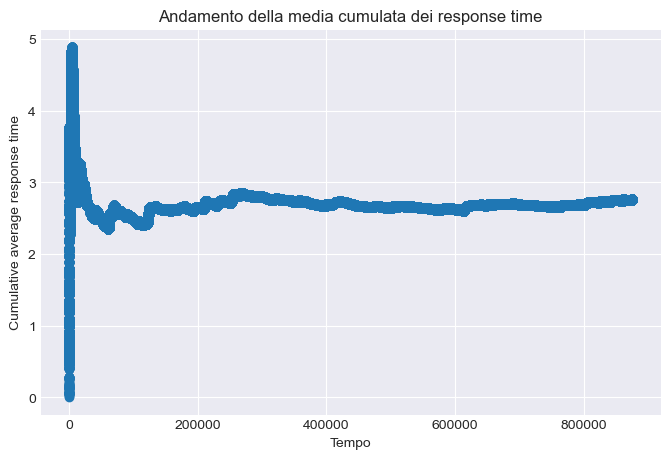

In [35]:
# Carichiamo il file CSV in dfJobs (usa direttamente le intestazioni del file)
dfJobs = pd.read_csv("csv/Jobs.csv")

# Calcolo della media cumulata dei response time
dfJobs["cumulative_avg"] = dfJobs["ResponseTime"].expanding().mean()

# Mostriamo un estratto per verifica
print(dfJobs[["Departure", "ResponseTime", "cumulative_avg"]].head())

# Grafico
plt.figure(figsize=(8,5))
plt.plot(dfJobs["Departure"], dfJobs["cumulative_avg"], marker="o", linestyle="-")
plt.xlabel("Tempo")
plt.ylabel("Cumulative average response time")
plt.title("Andamento della media cumulata dei response time")
plt.grid(True)
plt.show()

/tmp/ipykernel_10979/1738293152.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/flavio/.local/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


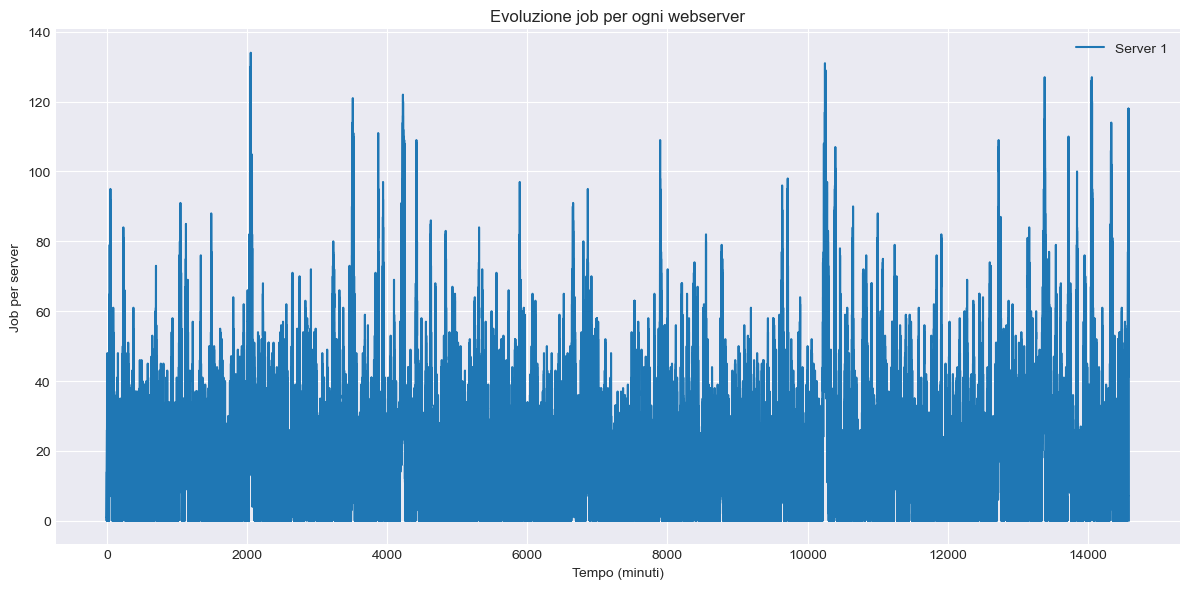

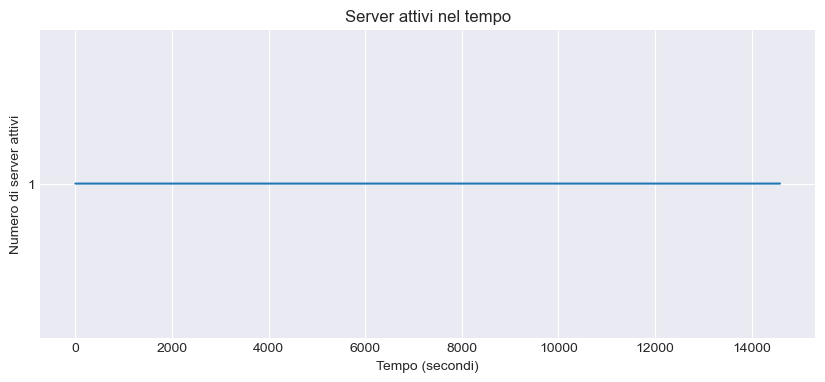

In [39]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# 📥 Carica il CSV con header
df = pd.read_csv("csv/Servers.csv", dtype={"timestamp": float})

# Se vuoi avere interi ma con NA ammessi
df["active_web_servers"] = pd.to_numeric(df["active_web_servers"], errors="coerce").astype("Int64")

# 🔎 Parser per la colonna active_jobs_per_webserver (es. "[null,3]")
def parse_jobs(val):
    if pd.isna(val):
        return []
    s = str(val).strip()
    if s == "" or s.lower() == "nan":
        return []
    try:
        return json.loads(s)   # "[null,3]" -> [None, 3]
    except Exception:
        return []

df["jobs_list"] = df["active_jobs_per_webserver"].apply(parse_jobs)

# 🔢 Numero massimo di server che compaiono
max_servers = int(df["jobs_list"].apply(len).max() or 0)

# 🔄 Espansione in colonne server_1, server_2, ...
for i in range(max_servers):
    df[f"server_{i+1}_jobs"] = df["jobs_list"].apply(
        lambda lst: lst[i] if i < len(lst) else None
    )

# ⏱️ Converte timestamp in minuti
minutes = df["timestamp"] / 60.0

# 📈 Grafico: evoluzione job per server
plt.figure(figsize=(12, 6))
for i in range(max_servers):
    plt.step(minutes, df[f"server_{i+1}_jobs"], where="post", label=f"Server {i+1}")

plt.xlabel("Tempo (minuti)")
plt.ylabel("Job per server")
plt.title("Evoluzione job per ogni webserver")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 📈 Grafico: numero di server attivi nel tempo
plt.figure(figsize=(10, 4))
plt.step(minutes, df["active_web_servers"], where="post")
plt.xlabel("Tempo (secondi)")
plt.ylabel("Numero di server attivi")
plt.title("Server attivi nel tempo")
plt.grid(True)
plt.yticks(
    range(int(df["active_web_servers"].min()), int(df["active_web_servers"].max()) + 1)
)
plt.show()


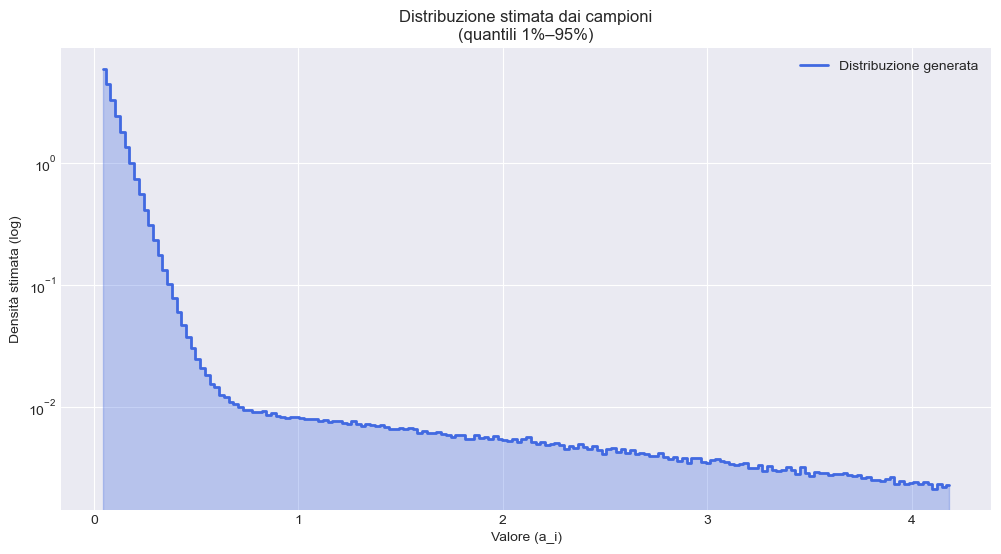

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df_generated = pd.read_csv("csv/stimated_hyperexponential.csv")

# Taglio: quantili sinistra e destra
low_q, high_q = 0.01, 0.95
a_min = df_generated["a_i"].quantile(low_q)
a_max = df_generated["a_i"].quantile(high_q)
df_cut = df_generated[(df_generated["a_i"] >= a_min) & (df_generated["a_i"] <= a_max)]

plt.figure(figsize=(12, 6))
plt.style.use("seaborn-v0_8-darkgrid")

# Disegno istogramma a scalini
plt.step(df_cut["a_i"], df_cut["density"],
         where="mid", color="royalblue", linewidth=2, label="Distribuzione generata")

plt.fill_between(df_cut["a_i"], df_cut["density"], step="mid",
                 color="royalblue", alpha=0.3)

# Opzione: scala logaritmica sull’asse y
plt.yscale("log")

plt.xlabel("Valore (a_i)")
plt.ylabel("Densità stimata (log)")
plt.title(f"Distribuzione stimata dai campioni\n(quantili {int(low_q*100)}%–{int(high_q*100)}%)")
plt.legend()
plt.show()


In [38]:
import pandas as pd
import ast

# 📥 Leggi il CSV
df = pd.read_csv("csv/Servers.csv")

# 🔎 Converte la colonna da stringa "[1]" -> lista [1]
df["active_jobs_per_webserver"] = df["active_jobs_per_webserver"].apply(ast.literal_eval)

# 🔢 Espande le liste (ciascuna riga può avere più server)
all_jobs = [job for sublist in df["active_jobs_per_webserver"] for job in sublist]

# 📊 Calcola la media
media = sum(all_jobs) / len(all_jobs) if all_jobs else 0.0

print("Media dei job per webserver:", media)


Media dei job per webserver: 16.78306323976564


In [49]:
# 📊 Algoritmo IE - Intervallo di Confidenza per la media incognita μ

import numpy as np
from scipy import stats

def intervallo_confidenza(x_bar, s, n, alpha=0.05):
    """
    Calcola l'intervallo di confidenza per la media incognita μ
    usando la distribuzione t di Student.
    
    Parametri:
    - x_bar : media campionaria
    - s     : deviazione standard campionaria
    - n     : dimensione campione (n > 1)
    - alpha : livello di significatività (default 0.05 -> 95% confidenza)
    """
    # valore critico t*
    t_star = stats.t.ppf(1 - alpha/2, df=n-1)
    
    # margine di errore
    margin = t_star * s / np.sqrt(n)
    
    # estremi intervallo
    ci_low, ci_high = x_bar - margin, x_bar + margin
    
    return ci_low, ci_high

# 🔎 Esempio d’uso:
x_bar = 2.688794628921501   # media campionaria
s     = 14.496826627284312   # deviazione standard campionaria
n     = 4132724    # dimensione campione
alpha = 0.001  # livello di significatività

ci = intervallo_confidenza(x_bar, s, n, alpha)

print(f"Intervallo di confidenza al {100*(1-alpha):.0f}%:")
print(f"[ {ci[0]:.4f} , {ci[1]:.4f} ]")



Intervallo di confidenza al 100%:
[ 2.6653 , 2.7123 ]
